In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

In [20]:
# Network Parameters
num_input = 38
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [21]:
def read_sensor(filename):
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 1:39])
    data_y = np.array(dataset.iloc[:, 40:41])

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    cur_dir = 1
    if(all_foot[0] == 'L'):
        cur_dir = 0
    strike_times.append([0.0, cur_dir])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[0:10])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])
         
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x_part))
    
    data_x, window_y = [], []
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
    
    return data_x, window_y

In [22]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'GD'])
    step_data_list.append([i, 1, '1L', 'WC'])
    step_data_list.append([i, 1, '2R', 'GD'])
    step_data_list.append([i, 1, '2R', 'WC'])
    step_data_list.append([i, 2, '1L', 'WC'])
    step_data_list.append([i, 2, '2R', 'WC'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [1, 1, '1L', 'WC'], [1, 1, '2R', 'GD'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [2, 1, '1L', 'GD'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'GD'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [3, 1, '1L', 'GD'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'GD'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [4, 1, '1L', 'GD'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'GD'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [5, 1, '1L', 'GD'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'GD'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'], [5, 2, '2R', 'WC']]


In [23]:
data_x, window_y = [], []
for i in step_data_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    data_x.extend(data_x_segement)
    window_y.extend(window_y_segement)
    
print(len(data_x)) #93638
print(len(window_y))

126384
126384


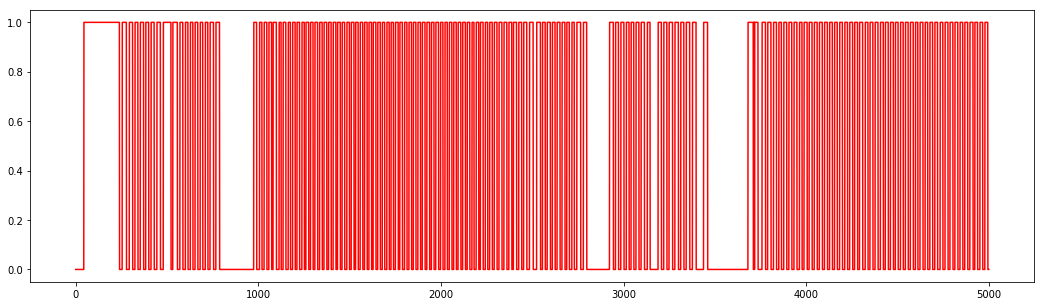

In [24]:
plt.figure(figsize=(18, 5))
start=20000
end=25000
#time back to 0
# plt.plot([i[0][0] for i in data_x[start:end]], [i[0] for i in window_y[start:end]], 'r')
plt.plot([i[0] for i in window_y[start:end]], 'r')
plt.show()

In [25]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

126384


In [26]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '1L', 'WC'])
    step_test_list.append([i, 1, '2R', 'GD'])
    step_test_list.append([i, 1, '2R', 'WC'])
    step_test_list.append([i, 2, '1L', 'WC'])
    step_test_list.append([i, 2, '2R', 'WC'])
    
print(step_test_list)

[[6, 1, '1L', 'GD'], [6, 1, '1L', 'WC'], [6, 1, '2R', 'GD'], [6, 1, '2R', 'WC'], [6, 2, '1L', 'WC'], [6, 2, '2R', 'WC']]


In [27]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(window_y_segement)
    
print(len(test_x))
print(len(test_y))

17252
17252


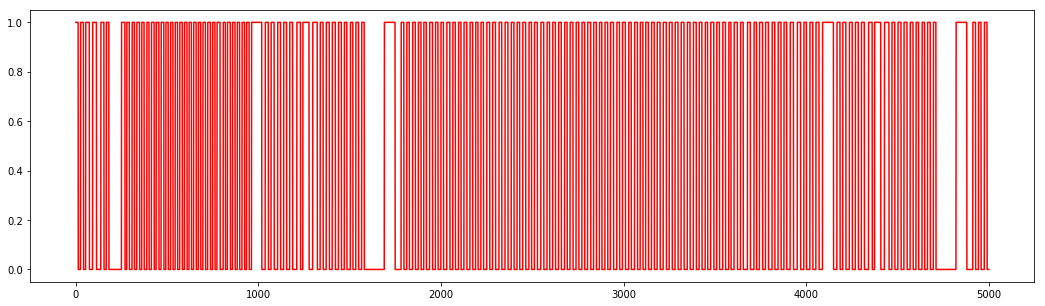

In [28]:
plt.figure(figsize=(18, 5))
start=10000
end=15000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.show()

In [29]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [30]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

126384
126384


In [31]:
train_x_extend.extend(train_x[0:batch_size])
train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

126640


In [32]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count/len(y)
#     print("train accuarcy : ", count/len(y))

In [33]:
training_steps = 12001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-data-12w-2w.ckpt-12000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-batch-data-12w-2w-show.ckpt', global_step=step)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 5.367966, train accuarcy : 0.000000
Loss at step 200: 0.247863, train accuarcy : 0.550781
Loss at step 400: 0.237775, train accuarcy : 0.589844
Loss at step 600: 0.231155, train accuarcy : 0.582031
Loss at step 800: 0.166818, train accuarcy : 0.800781
Loss at step 1000: 0.168107, train accuarcy : 0.753906
Loss at step 1200: 0.139008, train accuarcy : 0.828125
Loss at step 1400: 0.161098, train accuarcy : 0.753906
Loss at step 1600: 0.122321, train accuarcy : 0.835938
Loss at step 1800: 0.133935, train accuarcy : 0.839844
Loss at step 2000: 0.124154, train accuarcy : 0.816406
Loss at step 2200: 0.122273, train accuarcy : 0.839844
Loss at step 2400: 0.119085, train accuarcy : 0.855469
Loss at step 2600: 0.153277, train accuarcy : 0.792969
Loss at step 2800: 0.136134, train accuarcy : 0.789062
Loss at step 3000: 0.130455, train accuarcy : 0.812500
Loss at step 3200: 0.103331, train accuarcy : 0.847656
Loss at step 3400: 0.106476, train accuarcy : 0.839844
Loss 

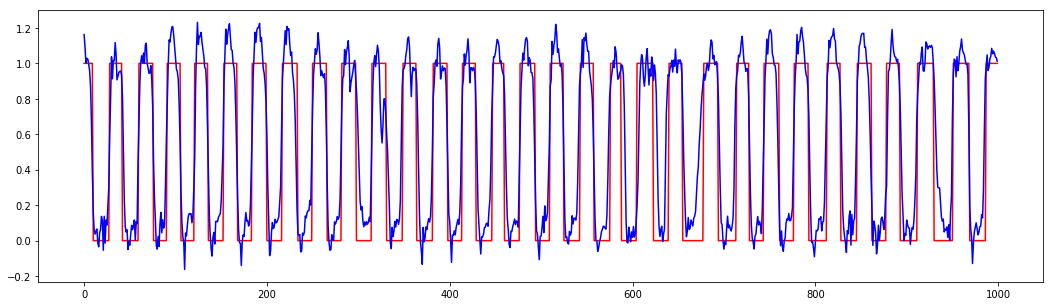

In [69]:
plt.figure(figsize=(18, 5))
start = 13000
end =14000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

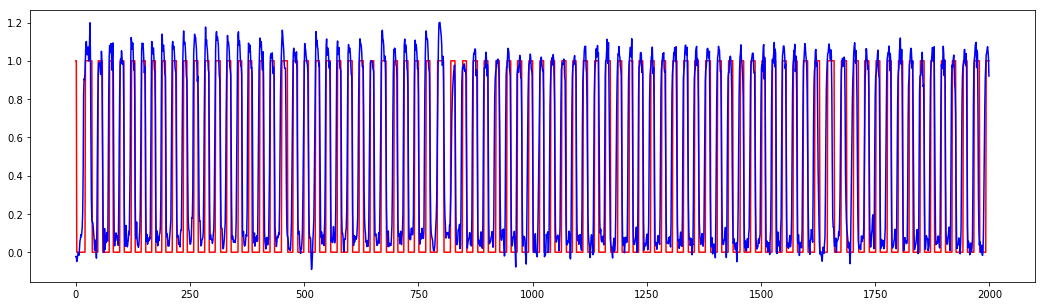

In [70]:
plt.figure(figsize=(18, 5))
start = 0
end =2000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

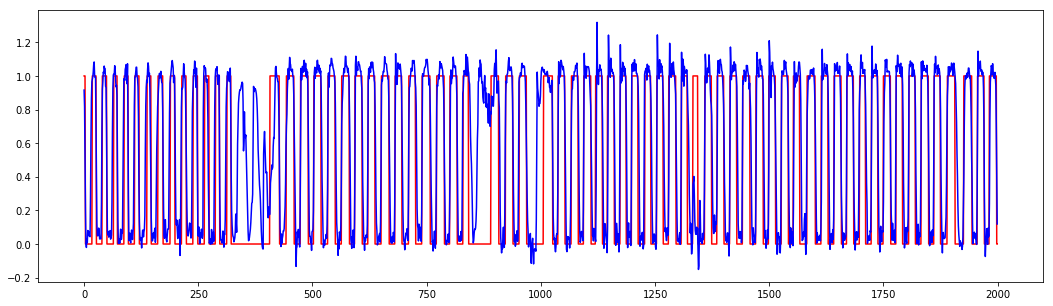

In [71]:
plt.figure(figsize=(18, 5))
start = 2000
end =4000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

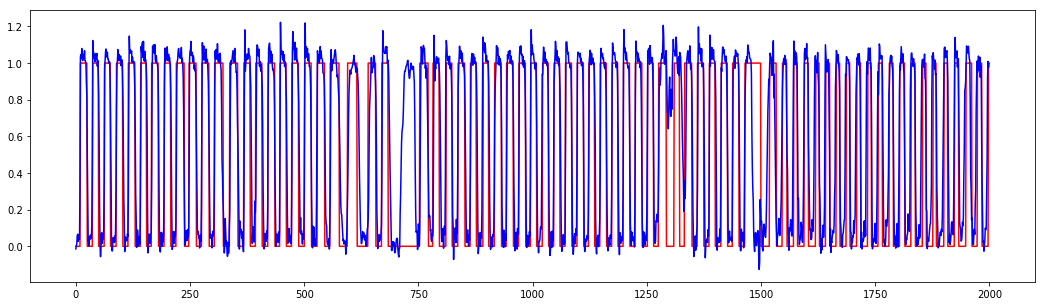

In [72]:
plt.figure(figsize=(18, 5))
start = 4000
end =6000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [73]:
print("test loss : ", test_loss)

count = 0
for i in range(0, len(test_x)):
    if(test_y[i][0] == round(test_logits[i][0])):
        count += 1;
print("test accuarcy : ", count/len(test_x))

test loss :  0.0975699
test accuarcy :  0.8760723394389056
